In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

In [91]:
df = pd.read_csv('./strains_with_id.csv')
df.head(20)

,name,description,parents,Aroused,Creative,Energetic,Euphoric,Focused,Giggly,Happy,...,Spasticity,Paranoid,Anxious,Dry Eyes,Dry Mouth,Headache,Stress,avg rating,num ratings,id
0,Sweet Nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,100.00,5.56,0.00,0.00,0.0,3.857143,6.0,hybrid:sweet-nina
1,Hawaiian Purple Kush,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.86,2.38,97.62,100.00,0.00,0.0,4.486486,32.0,indica:hawaiian-purple-kush
2,Lime Purple Mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,4.333333,4.0,indica:lime-purple-mist
3,F'n louZER,F’n louZER is another potent genetic cross fro...,"indica:bloos-kloos,indica:white-rhino,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,0.00,100.00,100.00,100.00,0.0,NaN,NaN,indica:fn-louzer
4,Goldwing,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,50.00,0.00,50.00,100.00,50.00,0.0,4.666667,2.0,sativa:goldwing
5,Arabian Gold,Arabian Gold is a heavy sativa strain of myste...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.50,0.00,62.50,100.00,0.00,0.0,4.100000,7.0,sativa:arabian-gold
6,Madagascar,"Madagascar is an indica with a clean, floral s...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,100.00,80.00,0.00,0.0,4.100000,7.0,indica:madagascar
7,Murkle,Murkle by OBSoul is the accidental genetic pai...,"indica:m-39,indica:purple-urkle,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.00,0.00,80.00,100.00,0.00,0.0,3.500000,2.0,indica:murkle
8,Berkeley,Berkeley is rumored to be the super-potent bot...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.67,100.00,83.33,66.67,50.00,0.0,4.315789,19.0,sativa:berkeley
9,Alf,The indica-dominant hybrid Alf was created by ...,"hybrid:animal-cookies,hybrid:cherry-pie,hybrid...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,5.000000,1.0,hybrid:alf


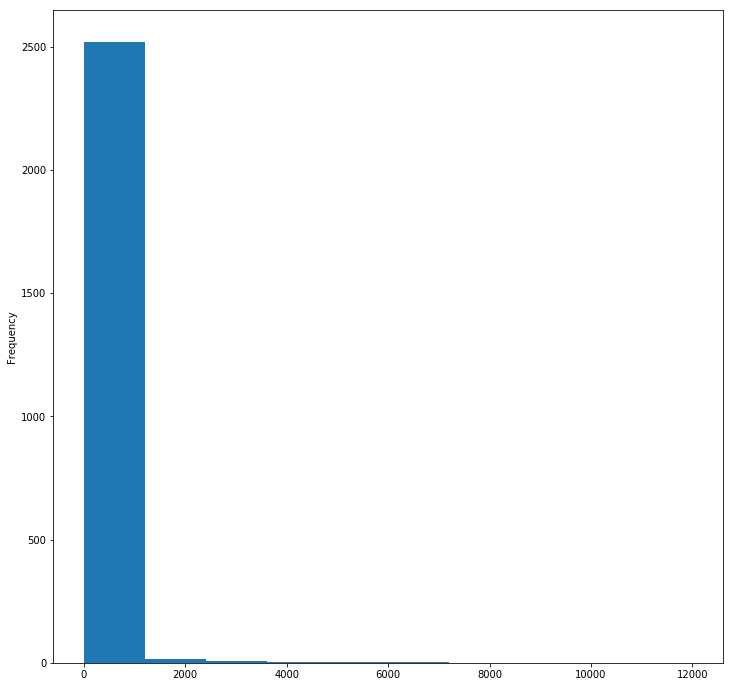

In [92]:
df['num ratings'].plot.hist(bins=10)

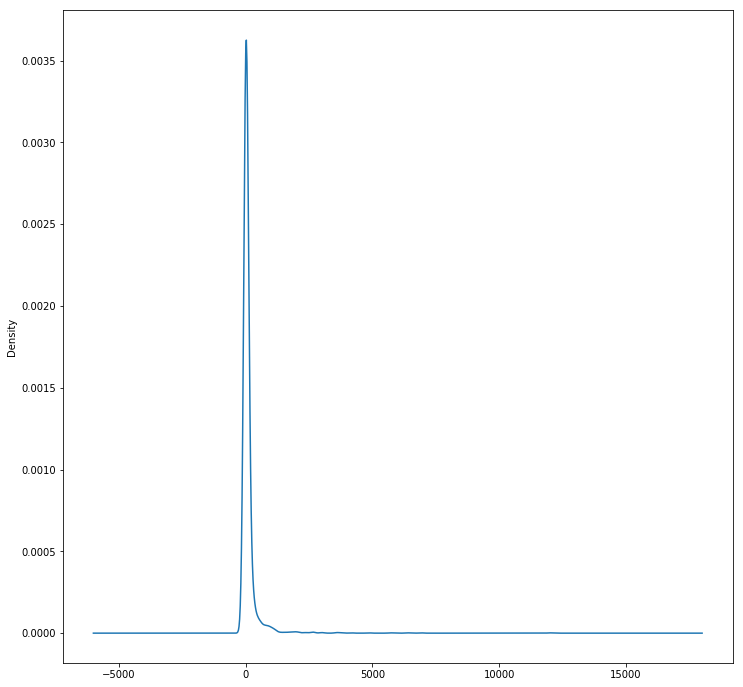

In [93]:
df['num ratings'].plot.density()

In [94]:
df.shape

(2669, 85)

In [95]:
parents=df['parents'].str.split(',',expand=True).head()
parents

,0,1,2,3,4,5,6,7
0,indica:hindu-kush,,None,None,None,None,None,None
1,sativa:hawaiian,indica:purple-kush,,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,,None,None,None,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
parents[7].unique()

array([None, nan], dtype=object)

In [97]:
# TODO Really need to get the flavor thing fixed.
df0=df
df0.shape

(2669, 85)

In [98]:
df1=df0#.dropna(subset=['num ratings'])
df1.shape

(2669, 85)

In [99]:
import json
# Handle name changes that redirect but the backend was never updated
substituition_dict = {"hybrid:girl-scout-cookie":"hybrid:gsc","hybrid:platinum-girl-scout-cookies":"hybrid:platinum-gsc","hybrid:platinum-girl-scout-cookie":"hybrid:platinum-gsc"}

def category(strain_id):
    categories = {"sativa":1,"hybrid":2,"indica":3}
    return categories[strain_id.split(':')[0]]
def distance(s1, s2):
#     d=1+abs(category(s1)-category(s2))
#     return d*d*d
    return 1

parent_ids=set() # All ids that show up in parents, thus we need them even if they don't have children
    
def precompute_ids(row):
        found_ids.add(row["id"])
        if (row["parents"] and type(row["parents"])==str):
            for p in row["parents"].split(','):
                if not len(p):
                    continue
                elif p in substituition_dict:
                    parent_ids.add(substituition_dict[p])
                else:
                    parent_ids.add(p)


found_ids=set()
missing_ids=set()
nodes = []
links = []
info = {}
def calculate(row):
    strain_id = row["id"]
    group = category(strain_id)
    parent_list = []
    if (row["parents"] and type(row["parents"]) == str):
        for p in row["parents"].split(','):
            if not len(p):
                continue
            elif p in substituition_dict:
                parent = substituition_dict[p]
            elif p not in found_ids:
                missing_ids.add(p)
                print("Strain %s is missing parent %s"%(strain_id,p))
                continue
            else:
                parent = p
            parent_list.append(parent) 
            # TODO what should the link value be? Do we even want one?
            links.append({ "source": parent, "target": strain_id, "value": distance(strain_id,parent) })
        row["parents"] = parent_list
    if len(parent_list) or strain_id in parent_ids:
        nodes.append({"id": strain_id, "name": row["name"], "group": group})
        info[strain_id]=row.to_json()
    else:
        print("Strain %s has no parents or children, discarding record" % strain_id,)
def reformat():

    df1.apply(precompute_ids,axis=1)        
    df1.apply(calculate,axis=1)
    if len(missing_ids):
        print("Warning, the following ids are missing and were ignored:")
        print(missing_ids)
    print("Total number of nodes output: %d" %len(nodes),) 
    
#     # TODO make this suck a bit less
reformat()
df_nodes=pd.DataFrame(data=nodes)
df_edges=pd.DataFrame(data=links)


Strain indica:lime-purple-mist has no parents or children, discarding record
Strain sativa:goldwing has no parents or children, discarding record
Strain sativa:arabian-gold has no parents or children, discarding record
Strain indica:madagascar has no parents or children, discarding record
Strain sativa:berkeley has no parents or children, discarding record
Strain hybrid:rocky-mountain-high has no parents or children, discarding record
Strain hybrid:broke-diesel has no parents or children, discarding record
Strain hybrid:the-boss has no parents or children, discarding record
Strain hybrid:smelliot has no parents or children, discarding record
Strain hybrid:el-na has no parents or children, discarding record
Strain indica:og-eddy-lepp has no parents or children, discarding record
Strain hybrid:x-file has no parents or children, discarding record
Strain hybrid:little-devil has no parents or children, discarding record
Strain hybrid:redding-og has no parents or children, discarding record


Strain sativa:1024 has no parents or children, discarding record
Strain hybrid:pink-lemonade has no parents or children, discarding record
Strain hybrid:sweet-kush has no parents or children, discarding record
Strain sativa:aceh has no parents or children, discarding record
Strain hybrid:avi has no parents or children, discarding record
Strain hybrid:savants-grail has no parents or children, discarding record
Strain hybrid:gorilla-snacks is missing parent hybrid:gg-4
Strain indica:zombie-og has no parents or children, discarding record
Strain hybrid:pheno-51 is missing parent hybrid:skywalker-og
Strain indica:diamond-og is missing parent Citrus
Strain indica:diamond-og is missing parent Pine
Strain indica:diamond-og is missing parent Woody
Strain hybrid:green-dream has no parents or children, discarding record
Strain sativa:nurse-jackie is missing parent Earthy
Strain sativa:nurse-jackie is missing parent Lemon
Strain sativa:nurse-jackie is missing parent Diesel
Strain sativa:nurse-jac

In [100]:
df_edges.head()

,source,target,value
0,indica:hindu-kush,hybrid:sweet-nina,1
1,sativa:hawaiian,indica:hawaiian-purple-kush,1
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,1


In [101]:
# Error: cycles that are clearly mistakes:
df_edges.drop(df_edges[((df_edges['target']=='indica:purple-afghani') & (df_edges['source']=='indica:purple-kush'))].index,inplace=True)
df_edges.drop(df_edges[((df_edges['target']=='sativa:timewreck') & (df_edges['source']=='sativa:timewreck'))].index,inplace=True)

In [102]:
bad_ids=df1[df1['num ratings']<100]['id']
bad_ids.head()

0              hybrid:sweet-nina
1    indica:hawaiian-purple-kush
2        indica:lime-purple-mist
4                sativa:goldwing
5            sativa:arabian-gold
Name: id, dtype: object

In [103]:
df_nodes.shape

(2186, 3)

In [104]:
df_nodes=df_nodes.drop(df_nodes[df_nodes['id'].isin(bad_ids)].index)
df_nodes.shape

(518, 3)

In [105]:
df_nodes.id.head()

2          indica:fn-louzer
8     hybrid:sunlight-skunk
9        hybrid:white-ryder
15    hybrid:peyton-manning
21        indica:pestilence
Name: id, dtype: object

In [106]:
df_edges.head()

,source,target,value
0,indica:hindu-kush,hybrid:sweet-nina,1
1,sativa:hawaiian,indica:hawaiian-purple-kush,1
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,1


In [107]:
df_edges[df_edges.target.isin(df_nodes.id)].head()

,source,target,value
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,1
16,hybrid:skunk-1,hybrid:sunlight-skunk,1
17,hybrid:lowryder,hybrid:white-ryder,1
29,hybrid:sfv-og,hybrid:peyton-manning,1


In [108]:
df_edges2=df_edges[df_edges.target.isin(df_nodes.id)]
df_edges2=df_edges2[df_edges2.source.isin(df_nodes.id)]
df_edges2.head()

,source,target,value
4,indica:white-rhino,indica:fn-louzer,1
29,hybrid:sfv-og,hybrid:peyton-manning,1
30,hybrid:chemdawg-91,hybrid:peyton-manning,1
41,indica:abusive-og,indica:pestilence,1
42,hybrid:og-kush,indica:ifc-og,1


In [109]:
# graph1[graph1['target']=='sativa:timewreck']

In [110]:
G=nx.DiGraph(df_edges,edge_attr=True)
G

In [111]:
are_good=nx.is_directed_acyclic_graph(G)
print("We are good if this says true: ",are_good)
if not are_good:
    print(nx.find_cycle(G))

We are good if this says true:  True


In [112]:
indegreeness=nx.in_degree_centrality(G)
source_nodes=[]
for x in indegreeness:
    if indegreeness[x] == 0:
        source_nodes.append(x)
print(source_nodes)

['indica:hindu-kush', 'sativa:hawaiian', 'hybrid:skunk-1', 'hybrid:og-kush', 'indica:frankenstein', 'hybrid:the-white', 'indica:pre-98-bubba-kush', 'indica:double-purple-doja', 'indica:silverback-gorilla', 'sativa:south-indian', 'hybrid:nebula', 'sativa:charlottes-web', 'indica:afghani', 'indica:sensi-star', 'indica:g-13', 'hybrid:bubble-gum', 'sativa:thai', 'sativa:central-american', 'hybrid:burmese-kush', 'sativa:super-lemon-haze', 'hybrid:ocas-cloud-9', 'indica:triangle-kush', 'sativa:strawberry-cough', 'hybrid:24k-gold', 'indica:north-indian', 'sativa:mexican', 'indica:eastern-european', 'hybrid:silver-surfer', 'hybrid:dutch-treat', 'sativa:matanuska-thunder-fuck', 'sativa:african', 'hybrid:the-one', 'sativa:lemon-thai', 'hybrid:ginger-ale', 'sativa:jamaican', 'hybrid:tahoe-alien', 'hybrid:blockhead', 'hybrid:california-orange', 'hybrid:saturn-og', 'indica:kosher-kush', 'indica:purple-elephant', 'sativa:nepalese', 'hybrid:green-ribbon', 'hybrid:pink-panther', 'sativa:south-american

In [ ]:
def calculate_layer(d):
    value = 0
    for s in source_nodes:
        if nx.has_path(G,s,d['id']):
            dist =nx.dijkstra_path_length(G,s,d['id'])
            if value < dist:
                value = dist
    return value
df_nodes['depth']=df_nodes.apply(calculate_layer,axis=1)
df_nodes.head(10)

In [ ]:
with open('strains_formatted.json','w') as outfile:
         json.dump({"nodes":df_nodes.to_dict(orient='records'), "links":df_edges2.to_dict(orient='records'),"info":info},outfile)